# Ring-assist Mach-Zehnder Interferometer (RAMZI) Modulators For advanced PAM and IQ modulation formats

### Mustafa Hammood - SiEPIC Actives Project

### RAMZM design and behavioral parameters

* <b>(lambda0)</b>: input laser wavelength
* <b>(R)</b>: Ring radius
* <b>(kappa)</b>: power coupling coefficient to the [ring resonator, out of ring resonator to monitor] (0-1)
* <b>(overlap)</b>: phase shifter region overlap percentage with the ring cavity (0-1)
* <b>(phi)</b>: initial, constant phase shift in the rings cavities [phi ring 1, phi ring 2] (radians)
* <b>(n1 and n2)</b>: waveguides effective index model
* <b>(alpha)</b>: waveguides propagation losses in dB/cm
* <b>(L_delta)</b>: imbalance between arms
* <b>(phi_arms)</b>: initial phase shift between the arms (radians)
* <b>(V_swing)</b>: Electrical voltage drive swing (V)

## Simulation parameters

* <b>(wavelength_start)</b>: simulation starting wavelength
* <b>(wavelength_stop)</b>: simulation end wavelength
* <b>(wavelength_pts)</b>: number of simulation points


In [165]:
!pip install numpy
!pip install matplotlib
!pip install scipy

import math, cmath
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

font = {'family' : "Times New Roman",
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

j = cmath.sqrt(-1)

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [166]:
lambda0 = 1523.47e-9

# ring cavity parameters (see description above for functionality)
R = 10e-6
kappa = [0.3, 0.03] # [Input-to-ring, ring-to-monitor] power coupling coefficient
phi = [0/np.pi, 0.785/np.pi]
overlap = 0.85

L_delta = 0e-9 # assume a built-in phase difference due to fab variations
phi_arms = np.pi/2

V_swing = 1 

# waveguides compact models
# these are polynomial fit constants for a strip waveguide width of 500 nm and height of 220 nm
n1 = 4.077182700600432
n2 = -0.982556173493906
n3 = -0.046366956781710

alpha = 3 # dB/cm

# simulation parameters
wavelength_start = 1520e-9
wavelength_stop = 1580e-9
wavelength_pts = 10001

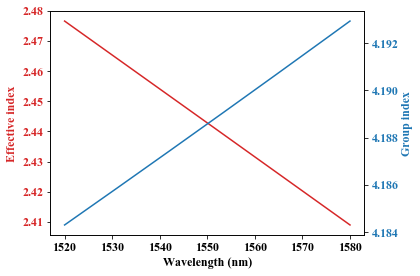

In [167]:
# wavelength span
wavelength = np.linspace( wavelength_start, wavelength_stop, wavelength_pts)

# compact model fits of effective indes (n_eff) and group index (n_g)
n_eff = n3*(wavelength*1e6)**2 + n2*(wavelength*1e6) + n1

# propogation constant of the waveguide
beta = 2*math.pi*n_eff/wavelength

n_g = []
for i in range(len(n_eff)-1):
    n_g.append(n_eff[i] - wavelength[i]*(n_eff[i]-n_eff[i+1])/(wavelength[i]-wavelength[i+1]))
    
# find index of operation wavelength
idx = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-lambda0))

# plot effective index and group index
fig_index, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Effective index', color=color)
ax1.plot(wavelength*1e9, n_eff, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Group index', color=color)
ax2.plot(wavelength[:-1]*1e9, n_g)
ax2.tick_params(axis='y', labelcolor=color)


fig_index.tight_layout()

## Ring analysis script (using Z transforms)
<img src="img/MRR.png" width="400">

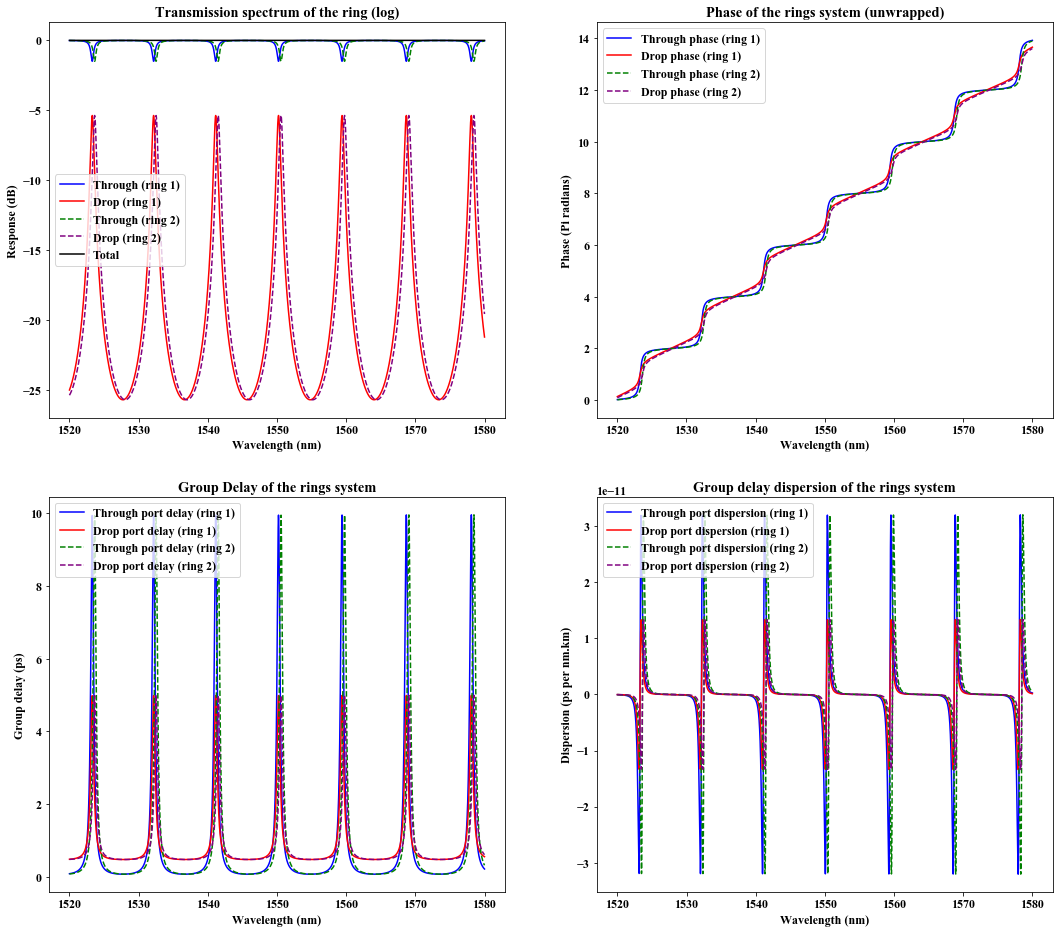

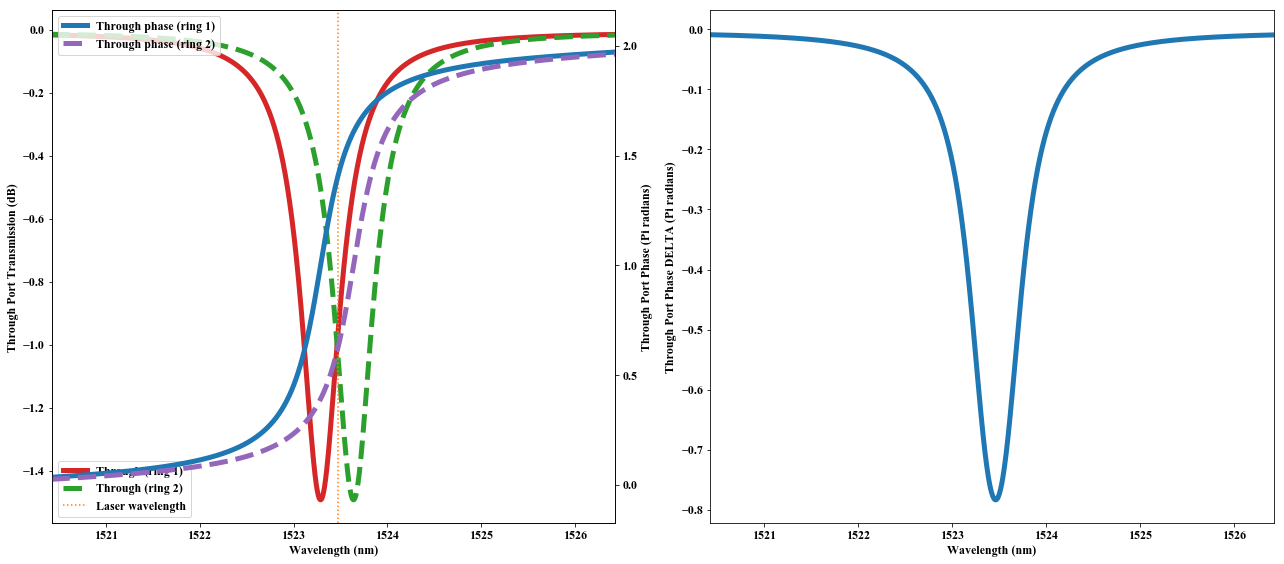

In [168]:
#%% ring transfer function
def RingS( kappa, phi, L, beta, alpha):
    j = cmath.sqrt(-1)
    gamma = 10**(-alpha*L/20)
    zeta  = gamma*np.exp(-j*phi)*np.exp(-j*beta*L)
    sqrtzeta  = math.sqrt(gamma)*np.exp(-j*phi/2)*np.exp(-j*beta*L/2)
    s     = math.sqrt(kappa)
    c     = math.sqrt(1-kappa)
    
    t1N = -j*s*sqrtzeta
    rN1 = c*zeta
    r1N = c
    tN1 = t1N
    
    S = [[t1N, rN1],[r1N, tN1]]
    return S

def MtoS( M ):
    t1N = M[0][0]*M[1][1]-M[0][1]*M[1][0]
    rN1 = M[0][1]
    r1N = -M[1][0]
    tN1 = 1;
    S_temp  = np.array([[t1N, rN1],[r1N, tN1]])
    S = (1/M[1][1]) * S_temp
    return S

def StoM( S ):
    A = S[0][0]*S[1][1]-S[0][1]*S[1][0]
    B = S[0][1]
    C = -S[1][0]
    D = 1
    M_temp = np.array([[A, B],[C, D]])
    M = (1/S[1][1])* M_temp
    return M

def Ring(kappa, phi, R, beta, alpha):
    t1N = [];r1N = [];rN1 = [];tN1 = []

    nor = 1 # sneaky modifier to scale this simulation to coupled rings system huehuehue :)
    L = 2*np.pi*R

    for beta0 in beta:
        S = RingS(kappa[0],phi,L,beta0,alpha)
        M = StoM(S)

        for no in range(nor):
            S = RingS(kappa[no+1],phi,L,beta0,alpha)

            Mtemp = StoM(S)
            M = np.matmul(Mtemp, M)

        S = MtoS( M )
        t1N.append(S[0][0]) # Electric field Drop
        rN1.append(S[0][1])
        r1N.append(S[1][0]) # Electric field Through
        tN1.append(S[1][1])

    #%% power
    Drop = t1N; 
    Thru = r1N; 
    
    return [Drop, Thru]

#%% power
[Drop_ring1, Thru_ring1] = Ring(kappa, phi[0], R, beta, alpha)
D_ring1 = np.absolute( Drop_ring1 )**2; DdB_ring1 = 10*np.log10(D_ring1)
T_ring1 = np.absolute( Thru_ring1 )**2; TdB_ring1 = 10*np.log10(T_ring1)

[Drop_ring2, Thru_ring2] = Ring(kappa, phi[1], R, beta, alpha)
D_ring2 = np.absolute( Drop_ring2 )**2; DdB_ring2 = 10*np.log10(D_ring2)
T_ring2 = np.absolute( Thru_ring2 )**2; TdB_ring2 = 10*np.log10(T_ring2)
TOT = D_ring1 + T_ring1; TOTdB = 10*np.log10(TOT)

#%% phase
Dphi_ring1 = np.angle(Drop_ring1); Dphi_ring1 = np.unwrap(Dphi_ring1)
Tphi_ring1 = np.angle(Thru_ring1); Tphi_ring1 = np.unwrap(Tphi_ring1)

Dphi_ring2 = np.angle(Drop_ring2); Dphi_ring2 = np.unwrap(Dphi_ring2)
Tphi_ring2 = np.angle(Thru_ring2); Tphi_ring2 = np.unwrap(Tphi_ring2)

#%% group delay
c      = 299792458
f      = c/wavelength
omega  = 2*math.pi*f
Tdelay_ring1 = -np.diff(Tphi_ring1)/np.diff(omega)
Ddelay_ring1 = -np.diff(Dphi_ring1)/np.diff(omega)

Tdelay_ring2 = -np.diff(Tphi_ring2)/np.diff(omega)
Ddelay_ring2 = -np.diff(Dphi_ring2)/np.diff(omega)

#%% dispersion
Tdispersion_ring1 = np.diff(Tdelay_ring1)/np.diff(omega[0:len(omega)-1])
Ddispersion_ring1 = np.diff(Ddelay_ring1)/np.diff(omega[0:len(omega)-1])

Tdispersion_ring2 = np.diff(Tdelay_ring2)/np.diff(omega[0:len(omega)-1])
Ddispersion_ring2 = np.diff(Ddelay_ring2)/np.diff(omega[0:len(omega)-1])

#%% plot spectrums
fig_ring, axs = plt.subplots(2,2, figsize=(18, 16))
lambda_0 = wavelength

axs[0, 0].set_title('Transmission spectrum of the ring (log)')
axs[0, 0].plot(lambda_0*1e9,TdB_ring1, label='Through (ring 1)', color='blue')
axs[0, 0].plot(lambda_0*1e9,DdB_ring1, label='Drop (ring 1)', color='red')
axs[0, 0].plot(lambda_0*1e9,TdB_ring2, '--', label='Through (ring 2)', color='green')
axs[0, 0].plot(lambda_0*1e9,DdB_ring2, '--', label='Drop (ring 2)', color='purple')
axs[0, 0].plot(lambda_0*1e9,TOTdB, label = 'Total', color='black')
axs[0, 0].set_xlabel("Wavelength (nm)")
axs[0, 0].set_ylabel("Response (dB)")
axs[0, 0].legend(loc=0)

axs[0, 1].set_title('Phase of the rings system (unwrapped)')
axs[0, 1].plot(lambda_0*1e9,Tphi_ring1/math.pi, label='Through phase (ring 1)', color='blue')
axs[0, 1].plot(lambda_0*1e9,Dphi_ring1/math.pi, label='Drop phase (ring 1)', color='red')
axs[0, 1].plot(lambda_0*1e9,Tphi_ring2/math.pi, '--',label='Through phase (ring 2)', color='green')
axs[0, 1].plot(lambda_0*1e9,Dphi_ring2/math.pi, '--',label='Drop phase (ring 2)', color='purple')
axs[0, 1].set_xlabel("Wavelength (nm)")
axs[0, 1].set_ylabel("Phase (Pi radians)")
axs[0, 1].legend(loc=0)

lambda_1 = lambda_0[0:len(lambda_0)-1]
axs[1, 0].set_title('Group Delay of the rings system')
axs[1, 0].plot(lambda_1*1e9,Tdelay_ring1*1e12, label='Through port delay (ring 1)', color='blue')
axs[1, 0].plot(lambda_1*1e9,Ddelay_ring1*1e12, label='Drop port delay (ring 1)', color='red')
axs[1, 0].plot(lambda_1*1e9,Tdelay_ring2*1e12, '--',label='Through port delay (ring 2)', color='green')
axs[1, 0].plot(lambda_1*1e9,Ddelay_ring2*1e12, '--',label='Drop port delay (ring 2)', color='purple')
axs[1, 0].set_xlabel("Wavelength (nm)")
axs[1, 0].set_ylabel("Group delay (ps)")
axs[1, 0].legend(loc=0)

lambda_2 = lambda_0[0:len(lambda_0)-2]
axs[1, 1].set_title('Group delay dispersion of the rings system')
axs[1, 1].plot(lambda_2*1e9,Tdispersion_ring1*1e12, label='Through port dispersion (ring 1)', color='blue')
axs[1, 1].plot(lambda_2*1e9,Ddispersion_ring1*1e12, label='Drop port dispersion (ring 1)', color='red')
axs[1, 1].plot(lambda_2*1e9,Tdispersion_ring2*1e12, '--',label='Through port dispersion (ring 2)', color='green')
axs[1, 1].plot(lambda_2*1e9,Ddispersion_ring2*1e12, '--',label='Drop port dispersion (ring 2)', color='purple')
axs[1, 1].set_xlabel("Wavelength (nm)")
axs[1, 1].set_ylabel("Dispersion (ps per nm.km)")
axs[1, 1].legend(loc=0)

# zoom-in on the through port spectrum of a resonance
# find a resonance
peaks = find_peaks(Tdispersion_ring1)
plt_range = int(wavelength_pts/20)
wl_resonance_start = wavelength[peaks[0][0]-plt_range]*1e9
wl_resonance_stop = wavelength[peaks[0][0]+plt_range]*1e9

fig_res, (ax1,ax3) = plt.subplots(1,2, figsize=(18, 8))
color = 'tab:red'
ax1.set_xlabel('Wavelength (nm)')
ax1.set_xlim(wl_resonance_start, wl_resonance_stop)
ax1.set_ylabel('Through Port Transmission (dB)')
ax1.plot(wavelength*1e9, TdB_ring1, color=color, label='Through (ring 1)', linewidth = 5)
ax1.plot(wavelength*1e9, TdB_ring2, '--',color='tab:green', label='Through (ring 2)', linewidth = 5)
ax1.axvline(x=lambda0*1e9, ls = ':', label = 'Laser wavelength', color = 'tab:orange')
ax1.legend(loc=0)

ax2 = ax1.twinx()
Tphi_ring1 = np.unwrap(np.angle(Thru_ring1))/math.pi
Tphi_ring2 = np.unwrap(np.angle(Thru_ring2))/math.pi
color = 'tab:blue'
ax2.set_ylabel('Through Port Phase (Pi radians)')
ax2.plot(lambda_0*1e9, Tphi_ring1, label='Through phase (ring 1)', linewidth = 5)
ax2.plot(lambda_0*1e9, Tphi_ring2, '--', color='tab:purple', label='Through phase (ring 2)', linewidth = 5)
ax2.set_ylim(Tphi_ring2[peaks[0][0]-plt_range]-0.2, Tphi_ring2[peaks[0][0]+plt_range]+0.2)
ax2.legend(loc=0)

ax3.set_xlabel('Wavelength (nm)')
ax3.set_xlim(wl_resonance_start, wl_resonance_stop)
ax3.set_ylabel('Through Port Phase DELTA (Pi radians)')
ax3.plot(lambda_0*1e9, Tphi_ring2-Tphi_ring1, linewidth = 5)
fig_res.tight_layout()
fig_res.savefig('fig_res.pdf', format = 'pdf')


## Ring-assisted Mach-Zehnder modulator transfer function (using Transfer Matrix Method)
<img src="img/RAMZI.png" width="600">

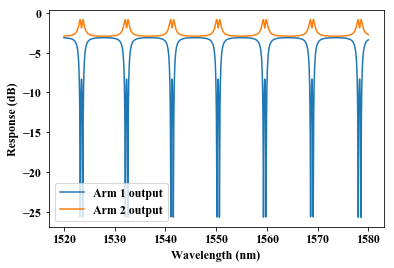

In [169]:
E_in = np.array([[1],[0]]) # light is inputted from arm 1 of 3 dB coupler

def RAMZI(L_delta, phi_arms, Thru_ring1, Thru_ring2):
    matrix_3dB = np.array([[1/np.sqrt(2), -j/np.sqrt(2)],[-j/np.sqrt(2), 1/np.sqrt(2)]])
    E_out = []; E_out1 = []; E_out2 = []
    L1 = 0
    L2 = L1 + L_delta
    for i in range(len(wavelength)):
        lambda0 = wavelength[i]
        beta_arm = 2*np.pi*n_eff[i] / lambda0
        phi1 = beta_arm*L1
        phi2 = beta_arm*L2+phi_arms
        matrix_wg = np.array([[0, np.exp(-j*phi1-alpha*L1)],[np.exp(-j*phi2-alpha*L2), 0]])
        matrix_rings = np.array([[0, Thru_ring1[i]],[Thru_ring2[i], 0]])
        matrix1 = np.matmul(matrix_3dB, matrix_wg)
        matrix2 = np.matmul(matrix1, matrix_rings)
        matrix3 = np.matmul(matrix2, matrix_3dB)

        E_out.append(np.matmul(matrix3, E_in))
        E_out1.append(E_out[i][0][0])
        E_out2.append(E_out[i][1][0])
    
    return [E_out1, E_out2]

[E_out1, E_out2] = RAMZI(L_delta, phi_arms, Thru_ring1, Thru_ring2)
fig_ramzm, axs = plt.subplots()
axs.plot(wavelength*1e9, 10*np.log10(np.abs(np.square(E_out1))), label = 'Arm 1 output')
axs.plot(wavelength*1e9, 10*np.log10(np.abs(np.square(E_out2))), label = 'Arm 2 output')
axs.set_xlabel("Wavelength (nm)")
axs.set_ylabel("Response (dB)")
axs.legend(loc=0)

## Voltage-induced wavelength shift (Δλ) across applied voltage swing (V_swing)
![PN](img/PN.png)

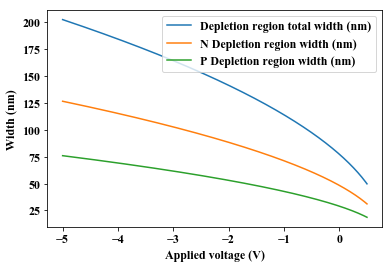

In [170]:
#%% constants
epsilon_r = 11.9 # relative permittivity of silicon
epsilon_o = 8.85e-12 # [F/m] free space permittivity
q = 1.602e-19 # [C] electron charge

k = 1.381e-23 # [j/K] Boltzmann constant
T = 290 # [K] Room temperature
ni = 1.5e16 # [/m^3] intrinsic carrier concentration

#%% design parameters

N = 3e17 # [/cm^3] n region doping concentration
P = 5e17 # [/cm^3] p region doping concentration
V = 0 # applied voltage

#%%
# convert units to [/m^3]
N = N/0.000001
P = P/0.000001

# built in potential
V_bi = k*T/q * np.log(N*P/(ni**2))

W_dep0 = np.sqrt( (2*epsilon_r*epsilon_o/q)*(V_bi-V)*(N+P)/(N*P))

x_n0 = np.sqrt((2*epsilon_r*epsilon_o/q)*(V_bi-V)*P/(N*(N+P)))
x_p0 = np.sqrt((2*epsilon_r*epsilon_o/q)*(V_bi-V)*N/(P*(N+P))) 

#%% sweep applied voltage
W_dep = []; x_n =[]; x_p = []

V_range = np.linspace(-5,0.5,1000)

for v in np.nditer(V_range):
    W_dep.append(1e9*np.sqrt( (2*epsilon_r*epsilon_o/q)*(V_bi-v)*(N+P)/(N*P)))
    x_n.append(1e9*np.sqrt((2*epsilon_r*epsilon_o/q)*(V_bi-v)*P/(N*(N+P))))
    x_p.append(1e9*np.sqrt((2*epsilon_r*epsilon_o/q)*(V_bi-v)*N/(P*(N+P))))

plt.plot(V_range, W_dep, label = 'Depletion region total width (nm)')
plt.plot(V_range, x_n, label = 'N Depletion region width (nm)')
plt.plot(V_range, x_p, label = 'P Depletion region width (nm)')
plt.legend()
plt.ylabel('Width (nm)')
plt.xlabel('Applied voltage (V)')
plt.savefig('fig_depletion.pdf', format = 'pdf')

d_lambda = V_swing*0.062e-9 # 62 pm based on a simple symmetrical PN diode (IME AMF process)


## Effective index variation (Δn<sub>eff</sub>) due to voltage-induced wavelength shift (Δλ)

In [171]:
# path length of the ring cavity
L = 2*np.pi*R

# FSR of the ring cavity at the operation wavelength
FSR = lambda0**2/(np.asarray(n_g)*L); FSR = FSR[idx]

# phase shifter length in ring cavity (L_A)
L_A = 2*np.pi*R*overlap

d_neff = lambda0 * d_lambda / (FSR*L_A) 


## Voltage-induced response of the RAMZM (dual-drive, push-pull operation, for OOK)

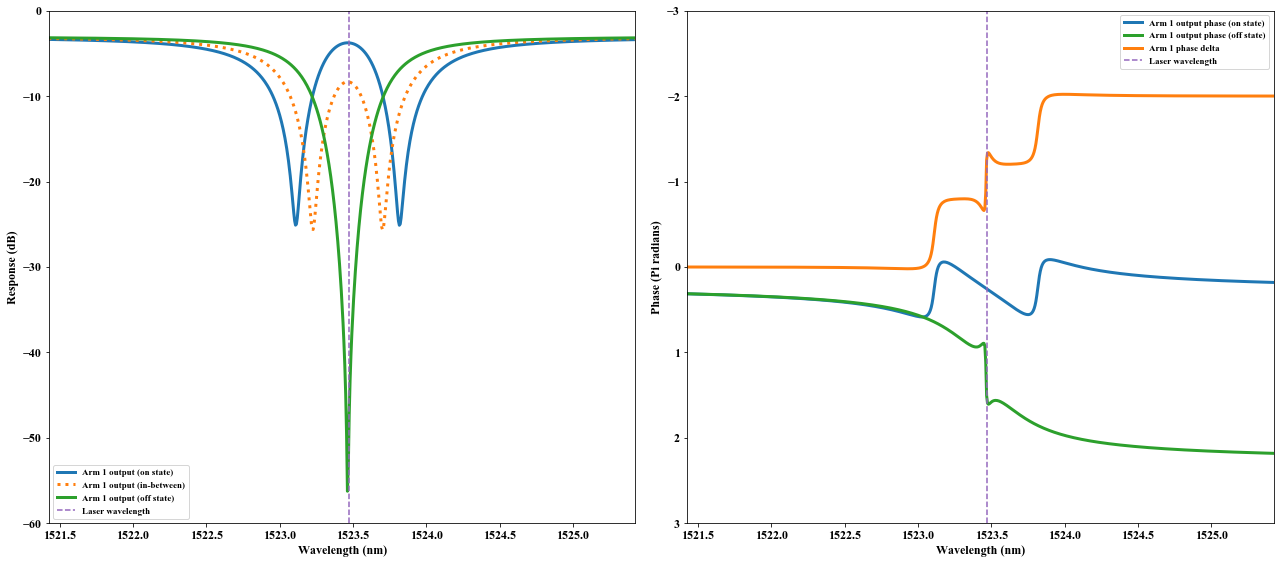

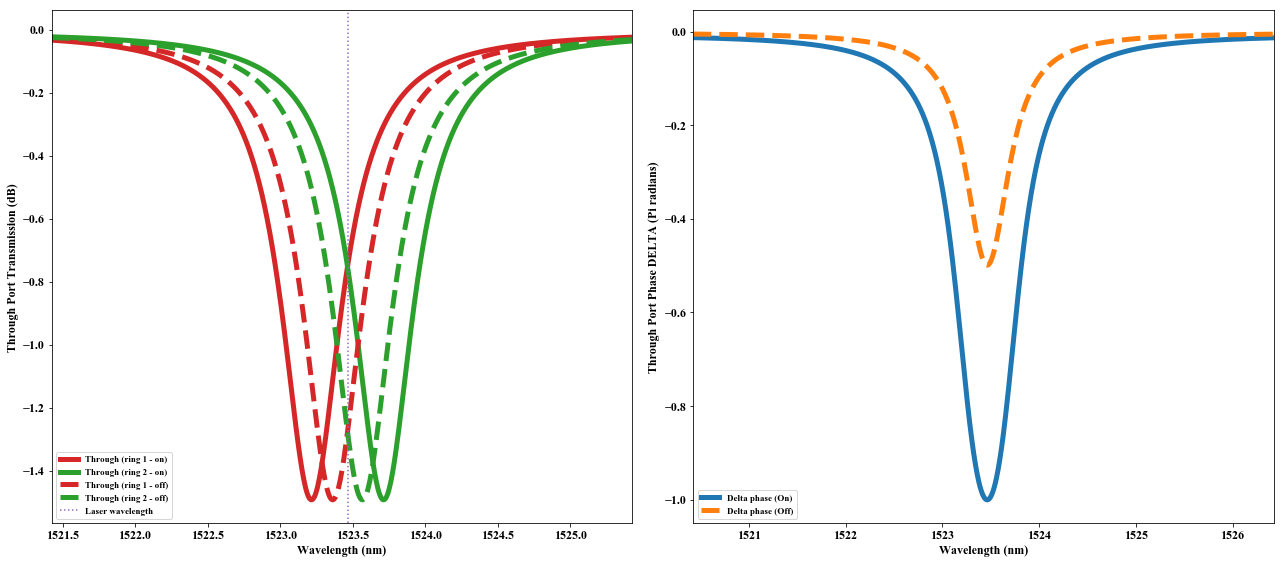

In [172]:
# propogation constant of the waveguide (pulled and pushed)
beta_pull = 2*math.pi*(n_eff-d_neff)/wavelength
beta_push = 2*math.pi*(n_eff+d_neff)/wavelength

#%% power during the two states
[Drop_ring1_on, Thru_ring1_on] = Ring(kappa, phi[0], R, beta_pull, alpha)
[Drop_ring2_on, Thru_ring2_on] = Ring(kappa, phi[1], R, beta_push, alpha)
[E_out1_on, E_out2_on] = RAMZI(L_delta, phi_arms, Thru_ring1_on, Thru_ring2_on)
E_out1_on_phase = np.angle( E_out1_on ); E_out1_on_phase = np.unwrap( E_out1_on_phase )/math.pi

[Drop_ring1_off, Thru_ring1_off] = Ring(kappa, phi[0], R, beta_push, alpha)
[Drop_ring2_off, Thru_ring2_off] = Ring(kappa, phi[1], R, beta_pull, alpha)
[E_out1_off, E_out2_off] = RAMZI(L_delta, phi_arms, Thru_ring1_off, Thru_ring2_off)
E_out1_off_phase = np.angle( E_out1_off ); E_out1_off_phase = np.unwrap( E_out1_off_phase )/math.pi

[Drop_ring1, Thru_ring1] = Ring(kappa, phi[0], R, beta, alpha)
[Drop_ring2, Thru_ring2] = Ring(kappa, phi[1], R, beta, alpha)
[E_out1, E_out2] = RAMZI(L_delta, phi_arms, Thru_ring1, Thru_ring2)


fig_modulation, (axs,ax1) = plt.subplots(1,2, figsize=(18, 8))
axs.plot(wavelength*1e9, 10*np.log10(np.abs(np.square(E_out1_on))), label = 'Arm 1 output (on state)', linewidth = 3)
axs.plot(wavelength*1e9, 10*np.log10(np.abs(np.square(E_out1))), ':', label = 'Arm 1 output (in-between)', linewidth = 3)
axs.plot(wavelength*1e9, 10*np.log10(np.abs(np.square(E_out1_off))), label = 'Arm 1 output (off state)', linewidth = 3)
axs.axvline(x=lambda0*1e9, ls = '--', label = 'Laser wavelength', color = 'tab:purple')
axs.set_xlim(wl_resonance_start+1, wl_resonance_stop-1)
axs.set_ylim(-60, 0)
axs.set_xlabel("Wavelength (nm)")
axs.set_ylabel("Response (dB)")
axs.legend(loc=0, prop={'size': 9})

ax1.plot(wavelength*1e9, E_out1_on_phase, label = 'Arm 1 output phase (on state)', linewidth = 3)
ax1.plot(wavelength*1e9, E_out1_off_phase, label = 'Arm 1 output phase (off state)', linewidth = 3, color = 'tab:green')
ax1.plot(wavelength*1e9, E_out1_on_phase-E_out1_off_phase, label = 'Arm 1 phase delta ', linewidth = 3)
ax1.axvline(x=lambda0*1e9, ls = '--', label = 'Laser wavelength', color = 'tab:purple')
ax1.set_xlim(wl_resonance_start+1, wl_resonance_stop-1)
ax1.set_ylim(3, -3)
ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel("Phase (Pi radians)")
ax1.legend(loc=0, prop={'size': 9})
fig_modulation.tight_layout()
fig_modulation.savefig('fig_modulation.pdf', format = 'pdf')

T_ring2_on = np.absolute( Thru_ring2_on )**2; TdB_ring2_on = 10*np.log10(T_ring2_on)
Tphi_ring2_on = np.angle( Thru_ring2_on ); Tphi_ring2_on = np.unwrap(Tphi_ring2_on)/math.pi

T_ring1_on = np.absolute( Thru_ring1_on )**2; TdB_ring1_on = 10*np.log10(T_ring1_on)
Tphi_ring1_on = np.angle( Thru_ring1_on ); Tphi_ring1_on = np.unwrap(Tphi_ring1_on)/math.pi

T_ring2_off = np.absolute( Thru_ring2_off )**2; TdB_ring2_off = 10*np.log10(T_ring2_off)
Tphi_ring2_off = np.angle( Thru_ring2_off ); Tphi_ring2_off = np.unwrap(Tphi_ring2_off)/math.pi

T_ring1_off = np.absolute( Thru_ring1_off )**2; TdB_ring1_off = 10*np.log10(T_ring1_off)
Tphi_ring1_off = np.angle( Thru_ring1_off ); Tphi_ring1_off = np.unwrap(Tphi_ring1_off)/math.pi


fig_modulation_rings, (ax1,axs) = plt.subplots(1,2, figsize=(18, 8))
color = 'tab:red'
ax1.set_xlabel('Wavelength (nm)')
ax1.set_xlim(wl_resonance_start, wl_resonance_stop)
ax1.set_ylabel('Through Port Transmission (dB)')
ax1.plot(wavelength*1e9, TdB_ring1_on, label='Through (ring 1 - on)', color = 'tab:red', linewidth = 5)
ax1.plot(wavelength*1e9, TdB_ring2_on, label='Through (ring 2 - on)', color = 'tab:green', linewidth = 5)
ax1.plot(wavelength*1e9, TdB_ring1_off, '--', label='Through (ring 1 - off)', color = 'tab:red', linewidth = 5)
ax1.plot(wavelength*1e9, TdB_ring2_off, '--', label='Through (ring 2 - off)', color = 'tab:green', linewidth = 5)
ax1.axvline(x=lambda0*1e9, ls = ':', label = 'Laser wavelength', color = 'tab:purple')
ax1.legend(loc=0, prop={'size': 9})
ax1.set_xlim(wl_resonance_start+1, wl_resonance_stop-1)

axs.set_xlabel('Wavelength (nm)')
axs.set_xlim(wl_resonance_start, wl_resonance_stop)
axs.set_ylabel('Through Port Phase DELTA (Pi radians)')
axs.plot(lambda_0*1e9, (Tphi_ring2_on-Tphi_ring1_on), label = 'Delta phase (On)', linewidth = 5)
axs.plot(lambda_0*1e9, (Tphi_ring2_off-Tphi_ring1_off), '--', label = 'Delta phase (Off)', linewidth = 5)
axs.legend(loc=0, prop={'size': 9})
fig_modulation_rings.tight_layout()
fig_modulation_rings.savefig('fig_modulation_rings.pdf', format = 'pdf')

Text(0,0.5,'Maximum Extinction Ratio (dB)')

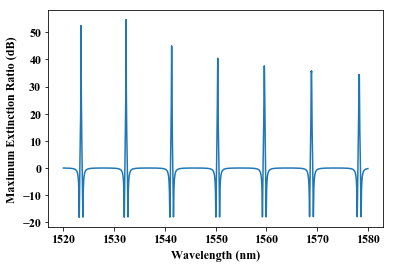

In [173]:
ER = 10*np.log10(np.abs(np.square(E_out1_on))) - 10*np.log10(np.abs(np.square(E_out1_off)))

fig_ER_IL, axs = plt.subplots()
axs.plot(wavelength*1e9, ER)
axs.set_xlabel("Wavelength (nm)"); axs.set_ylabel("Maximum Extinction Ratio (dB)")

In [174]:
def truncate(f, n):
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

IL = (10*np.log10(np.abs(np.square(E_out1_on[idx]))))

ER = IL - (10*np.log10(np.abs(np.square(E_out1_off[idx]))))

print('Insertion loss = '+str(IL)+' dB')
print('Extinction ratio = '+str(ER)+' dB')

Insertion loss = -3.758423438502252 dB
Extinction ratio = 49.49845627020524 dB
